In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import torch
from src.d05_regression_model import Trainer

torch.use_deterministic_algorithms(True) 


trainer = Trainer('cuda', tracking=False, experiment='Assembly Inspector Counter')
dls = trainer.get_dataloaders('./data/temp/counting_imgs/wheels_five/scale_0.2/screw', [3, 672, 378], 5, 'screw')


W1004 21:59:50.295000 165816 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


imgs_per_class 255


In [2]:
samples = {0:0, float(1/6):0, float(2/6):0, float(3/6):0, float(4/6):0, float(5/6):0, float(6/6):0}

for X, y in dls["train"]:
    for yy in y:
        samples[yy.item()] += 1

print(samples)

samples = {0:0, float(1/6):0, float(2/6):0, float(3/6):0, float(4/6):0, float(5/6):0, float(6/6):0, float(7/6):0}

for X, y in dls["test"]:
    for yy in y:
        samples[yy.item()] += 1

print(samples)

{0: 252, 0.16666666666666666: 255, 0.3333333333333333: 255, 0.5: 254, 0.6666666666666666: 255, 0.8333333333333334: 254, 1.0: 251}
{0: 1594, 0.16666666666666666: 383, 0.3333333333333333: 64, 0.5: 64, 0.6666666666666666: 64, 0.8333333333333334: 421, 1.0: 64, 1.1666666666666667: 0}


In [ ]:
trainer = Trainer('cuda', tracking=True, experiment='Assembly Inspector Counter')

In [ ]:
#model = trainer.train_model(folder='./data/temp/counting_imgs/screwdriver/scale_0.35', part='screwdriver', num_in_assembly=1)

In [ ]:
model = trainer.train_model(folder='./data/temp/counting_imgs/wheels_five/scale_0.2', part='screw', num_in_assembly=5, enable_profiler=True)

imgs_per_class 255
Training...
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
_ZN5cudnn21bn_bw_1C11_kernel_newIff6float2Li512ELb1E...         0.00%       0.000us         0.00%       0.000us       0.000us      11.980ms        12.06%      11.980ms     374.373us            32  
_ZN2at6native29vectorized_elementwise_kernelILi4ENS0...         0.00%       0.000us         0.00%       0.000us       0.000us      10.608ms        10.68%      10.608ms       2.

In [3]:
dls = trainer.get_dataloaders('./data/temp/counting_imgs/wheels_five/scale_0.2/screw', [3, 672, 378], 5, 'screw')

ValueError: invalid literal for int() with base 10: 'assembly'

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
#from PIL import Image
from torchvision.transforms.functional import to_pil_image
import math

def show_target_imgs(loader: DataLoader, target):
    _COLUMNS = 12
    imgs_num = 0
    
    for X, y in loader:
        for one_y in y:
            if one_y == target:
                imgs_num += 1
    print("Samples amount:", imgs_num)            

    rows = math.ceil(imgs_num / _COLUMNS)
    if rows in (0, 1):
        rows = 2

    f, ax = plt.subplots(rows, _COLUMNS, figsize=(15, 1*rows))

    for plot in ax.ravel():
        plot.set_xticks([])
        plot.set_yticks([])

    num = 0
    for X, y in loader:
        for i in range(len(X)):
            if y[i] == target:
                ax[num // _COLUMNS, num % _COLUMNS].imshow(to_pil_image(X[i]*0.5 + 0.5, mode="RGB"))
                num += 1

    plt.tight_layout(pad=0)
    plt.show()

show_target_imgs(dls['train'], 5)

In [1]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as transforms

normalize_arg = [0.5] * 3
img_transforms = transforms.Compose([transforms.ToImage(),
                    transforms.ToDtype(torch.float32, scale=True),
                    transforms.Normalize(normalize_arg, normalize_arg)])
ds = ImageFolder(root = "./data/check/wheels_five/scale_0.2/screw", transform=img_transforms,allow_empty=True)
dl = DataLoader(ds, batch_size=1000)

NameError: name 'DataLoader' is not defined

Fails: 96
Target: 4


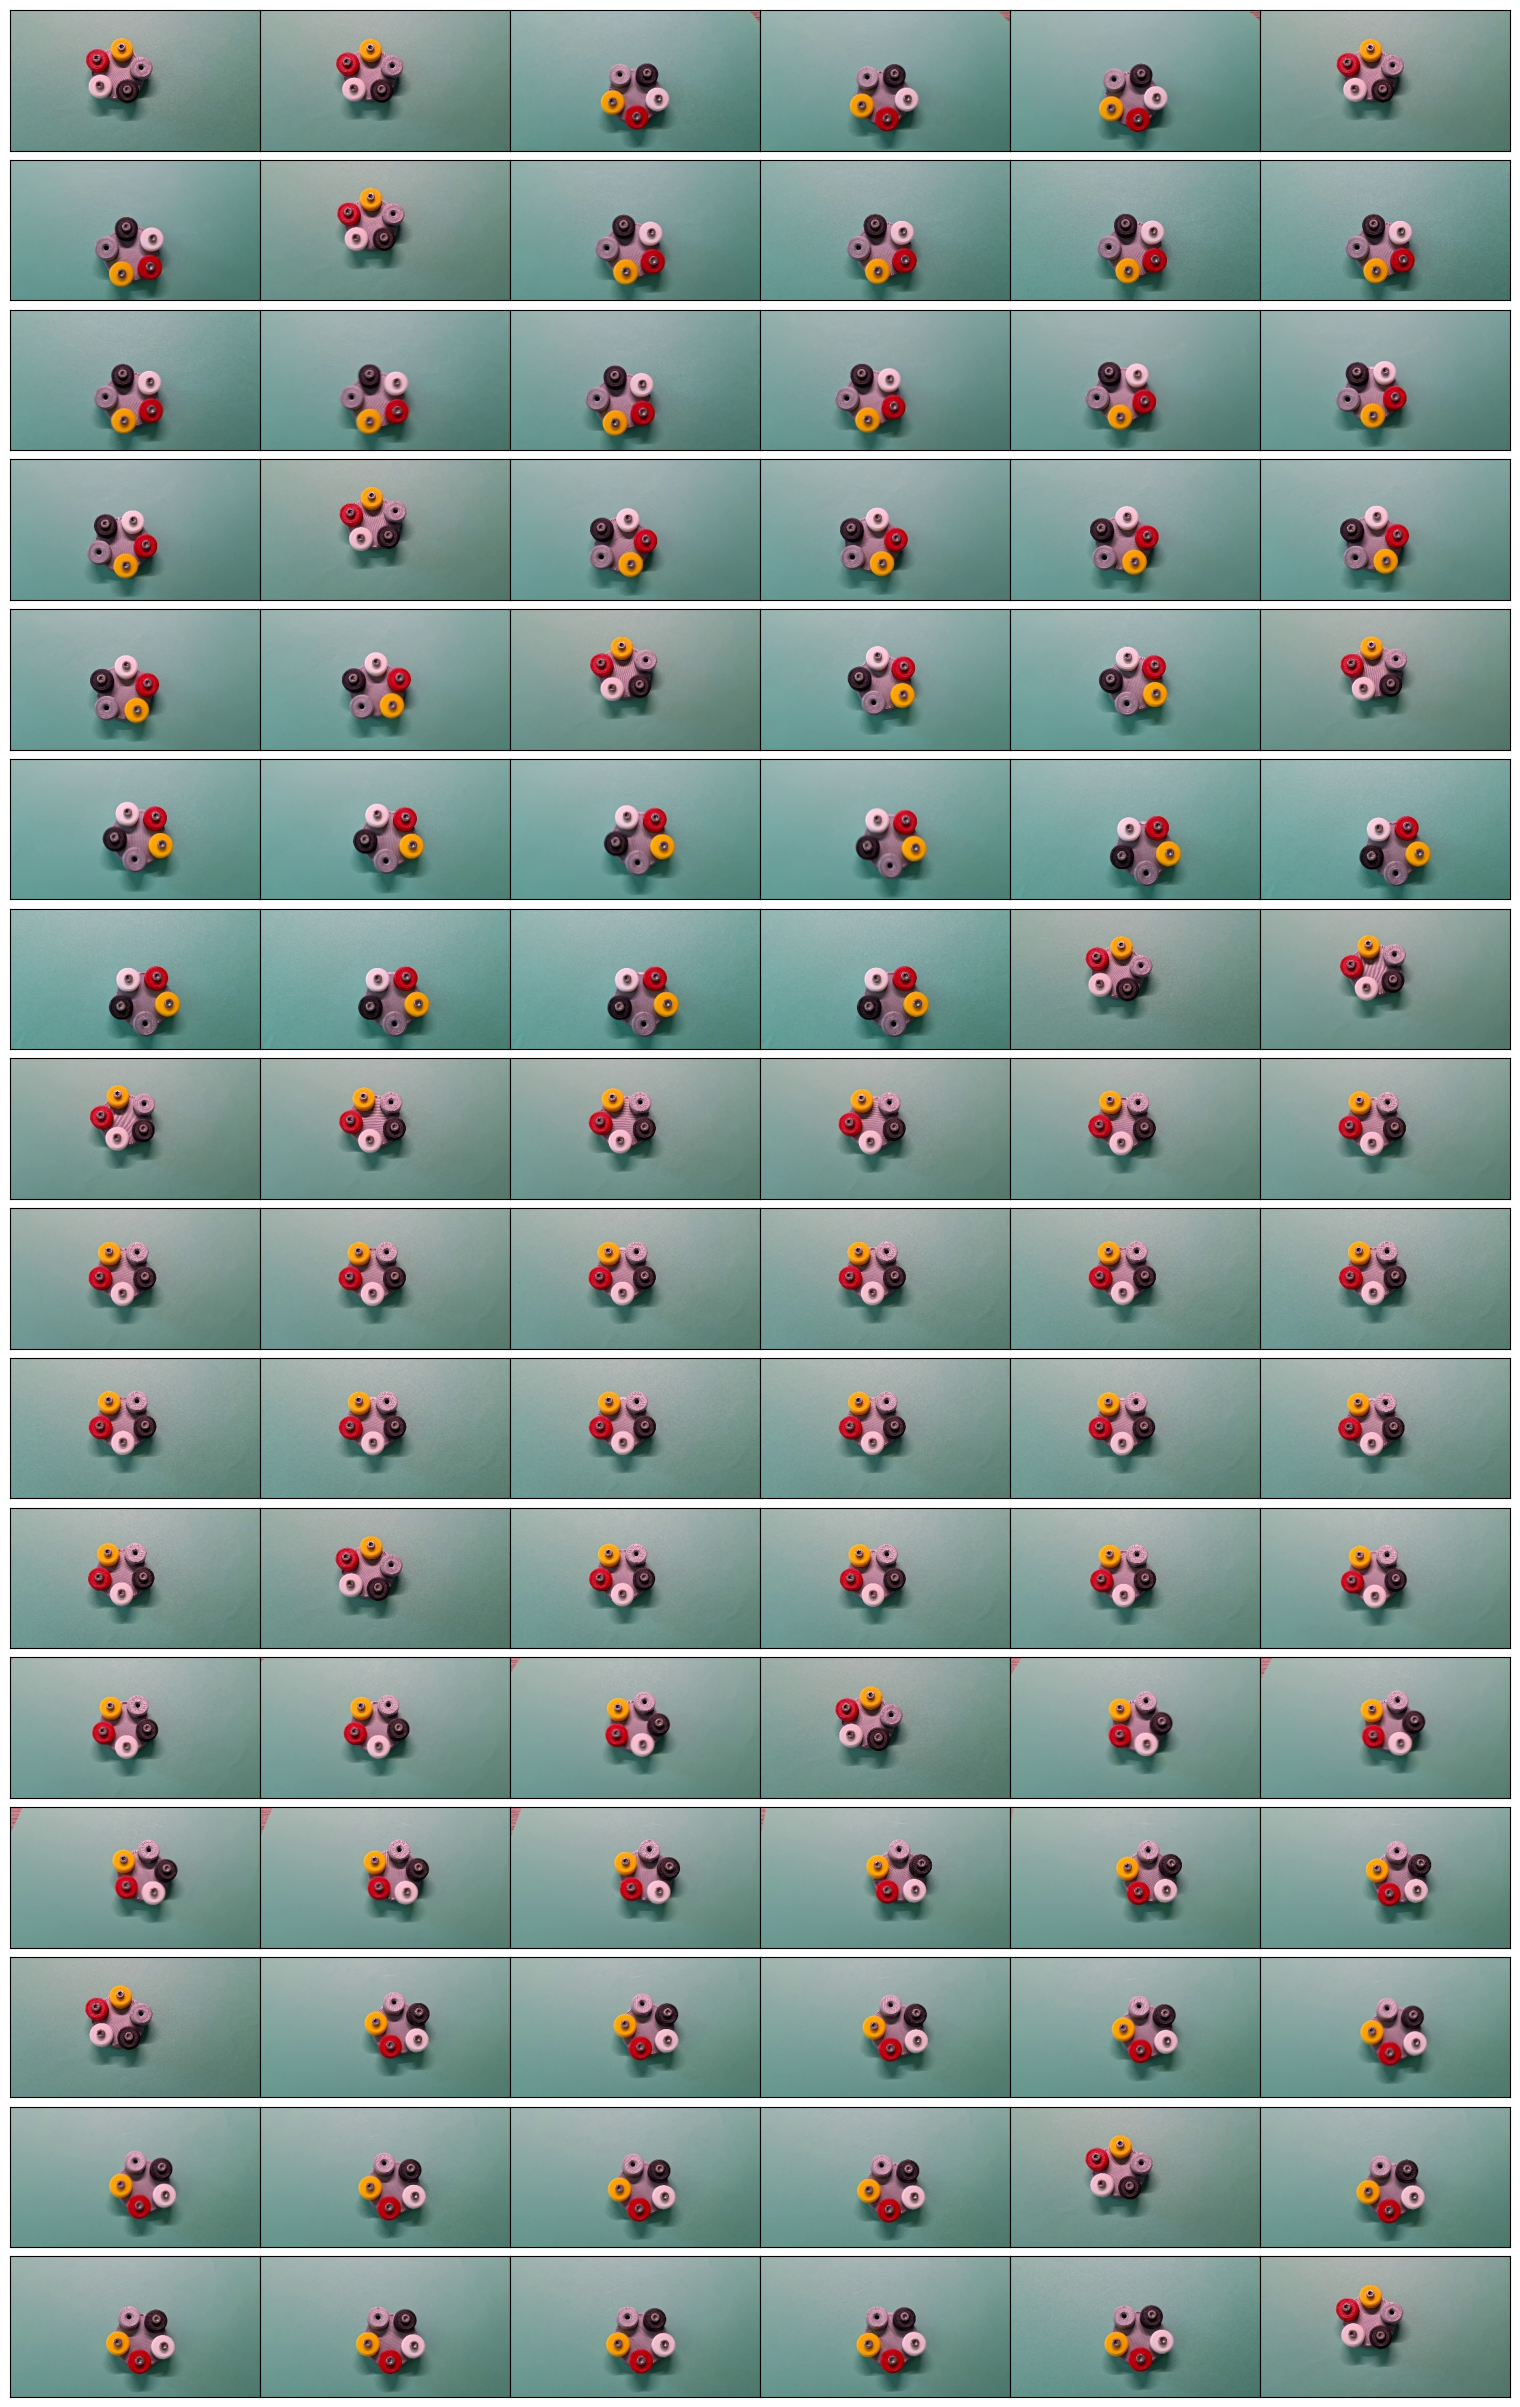

In [12]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
#from PIL import Image
from torchvision.transforms.functional import to_pil_image
import math
import mlflow
from torch import nn

def show_failed_imgs(loader: DataLoader, model_name:str, mlflow_url:str = "http://127.0.0.1:8080"):
    _COLUMNS = 6

    mlflow.set_tracking_uri(uri=mlflow_url)  
    model = mlflow.pytorch.load_model(f'models:/{model_name}').to('cpu') 

    targets = []
    fails = []    
    
    model.eval()
    with torch.no_grad():
        for X, y in loader:
            pred = model(X)
            
            for i in range(len(y)):
                if torch.round(pred[i]) !=  y[i]:
                    if y[i] not in targets:
                        targets.append(y[i])
                        fails.append([])
                    
                    fails[targets.index(y[i])].append(X[i])

    print("Fails:", sum([len(l) for l in fails])) 

    for i in range(len(targets)):
        print("Target:", targets[i].item())      

        rows = math.ceil(len(fails[i]) / _COLUMNS)
        if rows in (0, 1):
            rows = 2

        f, ax = plt.subplots(rows, _COLUMNS, figsize=(15, 1.5*rows))

        for plot in ax.ravel():
            plot.set_xticks([])
            plot.set_yticks([])
        
        for i2 in range(len(fails[i])):
            ax[i2 // _COLUMNS, i2 % _COLUMNS].imshow(to_pil_image(fails[i][i2]*0.5 + 0.5, mode="RGB"))

        plt.tight_layout(pad=0)
        plt.show()
show_failed_imgs(dl, model_name="._data_temp_counting_imgs_wheels_five_scale_0.2_screw_counter/43")
#show_failed_imgs(dls['test'][0], model_name="._data_temp_counting_imgs_wheels_five_scale_0.2_screw_counter/35")